<a href="https://colab.research.google.com/github/MyPham1207/Python_for_ML/blob/main/Assignments/Clustering%20click%20points%20on%20map/Day3_clustering_within_district.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Load libraries


In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy

In [ ]:
!pip install osmnet
!pip install matplotlib==3.1.3
!pip install osmnet
!pip install pandana
!pip install folium
!pip install rtree
!pip install pygeos

In [ ]:
import folium
from folium import plugins

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import json
import requests

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

from geopandas.tools import sjoin
import geopandas

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


#2.Load data

In [ ]:
%cd drive/My Drive/Python_for_ML/Assignment_2

/content/drive/My Drive/Python_for_ML/Assignment_2


In [ ]:
! git clone https://github.com/CityScope/CSL_HCMC

fatal: destination path 'CSL_HCMC' already exists and is not an empty directory.


##2.1.Load top 5 pop_increase district

In [ ]:
district = geopandas.read_file('CSL_HCMC/Data/GIS/Population/population_HCMC/population_shapefile/Population_District_Level.shp')
district

,Dist_Name,Dist_ID,Level,Pop_2009,Pop_2010,Pop_2011,Pop_2012,Pop_2013,Pop_2014,Pop_2015,Pop_2016,Pop_2017,Pop_2019,Den_2009,Den_2010,Den_2011,Den_2012,Den_2013,Den_2014,Den_2015,Den_2016,Den_2017,Den_2019,Shape_Leng,Shape_Area,geometry
0,District 1,760,District,180225.0,187435.0,187419.0,190943.0,197421.0,200297.0,193632.0,208475.0,211220.0,142625.0,23360.4000,24294.9000,24292.9000,24749.600,25589.300,25962.100,25098.200,27022.100,27377.900,18486.8000,15274.835115,7.714899e+06,"POLYGON ((684948.318 1193882.223, 684971.256 1..."
1,District 3,770,District,190553.0,188945.0,190631.0,191580.0,193206.0,193694.0,196333.0,198104.0,199095.0,190375.0,38688.6000,38362.1000,38704.4000,38897.100,39227.200,39326.300,39862.100,40221.700,40422.900,38652.5000,12182.058264,4.925215e+06,"POLYGON ((684382.122 1193521.050, 684410.753 1..."
2,District 4,773,District,180980.0,183261.0,184711.0,185649.0,185808.0,187157.0,186727.0,186995.0,183894.0,175329.0,43311.1000,43857.0000,44204.0000,44428.400,44466.500,44789.300,44686.400,44750.600,44008.400,41958.7000,9483.716891,4.178668e+06,"POLYGON ((687625.438 1189132.516, 687615.280 1..."
3,District 6,775,District,249329.0,253474.0,254212.0,257865.0,266121.0,257183.0,258945.0,260742.0,262757.0,233561.0,34910.5000,35490.8000,35594.2000,36105.700,37261.600,36010.200,36256.900,36508.500,36790.600,32702.7000,13077.365262,7.140945e+06,"POLYGON ((679534.413 1187518.498, 679077.904 1..."
4,District 7,778,District,244276.0,274828.0,268483.0,266633.0,280743.0,296757.0,310178.0,317488.0,327223.0,360155.0,6929.3900,7796.0600,7616.0700,7563.590,7963.850,8418.120,8798.840,9006.200,9282.350,10216.5000,33260.915360,3.525220e+07,"POLYGON ((691506.715 1190058.151, 691359.893 1..."
5,District 10,771,District,230345.0,232450.0,236336.0,237086.0,239180.0,238755.0,238558.0,239826.0,241327.0,234819.0,40354.6000,40723.4000,41404.2000,41535.600,41902.500,41828.000,41793.500,42015.600,42278.600,41138.5000,10478.512538,5.707881e+06,"POLYGON ((682507.505 1189929.778, 682485.431 1..."
6,District 11,772,District,226854.0,232536.0,236443.0,233499.0,227860.0,228030.0,230596.0,234291.0,237110.0,209867.0,44207.9000,45315.2000,46076.6000,45502.900,44404.000,44437.100,44937.200,45657.200,46206.600,40897.6000,10833.546511,5.131351e+06,"POLYGON ((681349.265 1190928.179, 681382.887 1..."
7,Phu Nhuan,768,District,174535.0,175175.0,177242.0,179917.0,180456.0,182821.0,182477.0,181780.0,183288.0,163961.0,35692.6000,35823.5000,36246.2000,36793.300,36903.500,37387.100,37316.800,37174.300,37482.600,33530.3000,12392.134315,4.889837e+06,"POLYGON ((682877.988 1195927.612, 682969.684 1..."
8,Tan Binh,766,District,421724.0,430436.0,434298.0,440351.0,443061.0,448989.0,455029.0,469526.0,470699.0,474792.0,18796.9000,19185.2000,19357.3000,19627.100,19747.900,20012.100,20281.400,20927.500,20979.800,21162.2000,23807.894025,2.243513e+07,"POLYGON ((680274.980 1198401.860, 680578.965 1..."
9,Binh Thanh,765,District,457362.0,470054.0,484135.0,484423.0,482833.0,485772.0,487985.0,489657.0,490618.0,499164.0,22005.5000,22616.2000,23293.7000,23307.600,23231.100,23372.500,23478.900,23559.400,23605.600,24016.8000,29544.712130,2.078389e+07,"POLYGON ((684986.154 1194412.964, 684987.226 1..."


In [ ]:
district = district.to_crs("EPSG:3857")

In [ ]:
district_top5 = district[['Dist_Name']]
district_top5['pop_increase'] = (district['Pop_2019']/district['Pop_2017']).to_frame()
district_top5 = district_top5.nlargest(5, 'pop_increase')
district_top5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Dist_Name,pop_increase
16,District 9,1.277619
23,Hoc Mon,1.215639
18,Nha Be,1.162071
22,District 12,1.129460
17,District 2,1.113104


In [ ]:
district = district[district['Dist_Name'].isin(district_top5['Dist_Name'])]
district

,Dist_Name,Dist_ID,Level,Pop_2009,Pop_2010,Pop_2011,Pop_2012,Pop_2013,Pop_2014,Pop_2015,Pop_2016,Pop_2017,Pop_2019,Den_2009,Den_2010,Den_2011,Den_2012,Den_2013,Den_2014,Den_2015,Den_2016,Den_2017,Den_2019,Shape_Leng,Shape_Area,geometry
16,District 9,763,District,256257.0,263486.0,271537.0,276432.0,284473.0,284990.0,290620.0,296198.0,310739.0,397006.0,2242.76,2306.02,2376.49,2419.33,2489.70,2494.23,2543.50,2592.32,2719.58,3474.59,53139.220230,1.142649e+08,"POLYGON ((11893391.506 1220647.065, 11893427.9..."
17,District 2,769,District,147490.0,140621.0,137749.0,134131.0,140436.0,140288.0,147168.0,153832.0,161957.0,180275.0,2953.46,2815.91,2758.40,2685.95,2812.21,2809.25,2947.02,3080.46,3243.16,3609.98,39592.970451,4.993869e+07,"POLYGON ((11882510.629 1210402.719, 11882734.6..."
18,Nha Be,786,District,101074.0,103793.0,110958.0,119416.0,126062.0,132034.0,139225.0,156001.0,177990.0,206837.0,1005.81,1032.87,1104.17,1188.34,1254.48,1313.90,1385.46,1552.41,1771.22,2058.29,67540.905029,1.004901e+08,"POLYGON ((11880366.970 1200552.160, 11880492.7..."
22,District 12,761,District,405360.0,427083.0,455881.0,475824.0,489511.0,499569.0,510326.0,526064.0,549064.0,620146.0,7680.92,8092.53,8638.21,9016.09,9275.44,9466.02,9669.85,9968.06,10403.90,11750.80,47703.394094,5.277342e+07,"POLYGON ((11877158.951 1220589.634, 11877173.0..."
23,Hoc Mon,784,District,349065.0,358640.0,366502.0,396763.0,408683.0,414795.0,422471.0,434275.0,446056.0,542243.0,3197.13,3284.83,3356.84,3634.00,3743.18,3799.16,3869.46,3977.58,4085.48,4966.47,65955.793966,1.091744e+08,"POLYGON ((11864832.709 1224020.903, 11864866.5..."


##2.2.Load click data

In [ ]:
hits = geopandas.read_file('/content/drive/MyDrive/Python_for_ML/Assignment_1/Data/response.json')
hits = hits.to_crs('epsg:3857')
hits

,dbh,geometry
0,1,POINT (11872019.034 1207329.487)
1,1,POINT (11877786.259 1210214.349)
2,1,POINT (11849918.369 1232062.826)
3,1,POINT (11878671.435 1213380.697)
4,1,POINT (11870186.812 1212580.637)
...,...,...
242548,1,POINT (11875366.294 1216664.038)
242549,1,POINT (11860397.293 1225426.030)
242550,1,POINT (11866397.741 1205067.331)
242551,1,POINT (11878694.812 1212408.254)


In [ ]:
click_data = geopandas.sjoin(hits, district, op='within')
click_data

,dbh,geometry,index_right,Dist_Name,Dist_ID,Level,Pop_2009,Pop_2010,Pop_2011,Pop_2012,Pop_2013,Pop_2014,Pop_2015,Pop_2016,Pop_2017,Pop_2019,Den_2009,Den_2010,Den_2011,Den_2012,Den_2013,Den_2014,Den_2015,Den_2016,Den_2017,Den_2019,Shape_Leng,Shape_Area
11,1,POINT (11875275.657 1217143.649),22,District 12,761,District,405360.0,427083.0,455881.0,475824.0,489511.0,499569.0,510326.0,526064.0,549064.0,620146.0,7680.92,8092.53,8638.21,9016.09,9275.44,9466.02,9669.85,9968.06,10403.90,11750.80,47703.394094,5.277342e+07
39,1,POINT (11870045.507 1219086.671),22,District 12,761,District,405360.0,427083.0,455881.0,475824.0,489511.0,499569.0,510326.0,526064.0,549064.0,620146.0,7680.92,8092.53,8638.21,9016.09,9275.44,9466.02,9669.85,9968.06,10403.90,11750.80,47703.394094,5.277342e+07
48,1,POINT (11873453.934 1216505.997),22,District 12,761,District,405360.0,427083.0,455881.0,475824.0,489511.0,499569.0,510326.0,526064.0,549064.0,620146.0,7680.92,8092.53,8638.21,9016.09,9275.44,9466.02,9669.85,9968.06,10403.90,11750.80,47703.394094,5.277342e+07
58,1,POINT (11871194.008 1216432.825),22,District 12,761,District,405360.0,427083.0,455881.0,475824.0,489511.0,499569.0,510326.0,526064.0,549064.0,620146.0,7680.92,8092.53,8638.21,9016.09,9275.44,9466.02,9669.85,9968.06,10403.90,11750.80,47703.394094,5.277342e+07
133,1,POINT (11871628.708 1216481.209),22,District 12,761,District,405360.0,427083.0,455881.0,475824.0,489511.0,499569.0,510326.0,526064.0,549064.0,620146.0,7680.92,8092.53,8638.21,9016.09,9275.44,9466.02,9669.85,9968.06,10403.90,11750.80,47703.394094,5.277342e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240978,1,POINT (11864925.547 1219705.959),23,Hoc Mon,784,District,349065.0,358640.0,366502.0,396763.0,408683.0,414795.0,422471.0,434275.0,446056.0,542243.0,3197.13,3284.83,3356.84,3634.00,3743.18,3799.16,3869.46,3977.58,4085.48,4966.47,65955.793966,1.091744e+08
240991,1,POINT (11863662.294 1215353.295),23,Hoc Mon,784,District,349065.0,358640.0,366502.0,396763.0,408683.0,414795.0,422471.0,434275.0,446056.0,542243.0,3197.13,3284.83,3356.84,3634.00,3743.18,3799.16,3869.46,3977.58,4085.48,4966.47,65955.793966,1.091744e+08
241569,1,POINT (11871919.701 1220286.156),23,Hoc Mon,784,District,349065.0,358640.0,366502.0,396763.0,408683.0,414795.0,422471.0,434275.0,446056.0,542243.0,3197.13,3284.83,3356.84,3634.00,3743.18,3799.16,3869.46,3977.58,4085.48,4966.47,65955.793966,1.091744e+08
241963,1,POINT (11875722.353 1221984.738),23,Hoc Mon,784,District,349065.0,358640.0,366502.0,396763.0,408683.0,414795.0,422471.0,434275.0,446056.0,542243.0,3197.13,3284.83,3356.84,3634.00,3743.18,3799.16,3869.46,3977.58,4085.48,4966.47,65955.793966,1.091744e+08


#3.KMeans clustering

In [ ]:
#Take coordination of click_data
click_data["longitude"] = click_data.geometry.map(lambda p: p.x)
click_data["latitude"] = click_data.geometry.map(lambda p: p.y)
click_points = click_data[['latitude', 'longitude', 'Dist_Name']]
click_points.groupby(by='Dist_Name')
click_points

,latitude,longitude,Dist_Name
11,1.217144e+06,1.187528e+07,District 12
39,1.219087e+06,1.187005e+07,District 12
48,1.216506e+06,1.187345e+07,District 12
58,1.216433e+06,1.187119e+07,District 12
133,1.216481e+06,1.187163e+07,District 12
...,...,...,...
240978,1.219706e+06,1.186493e+07,Hoc Mon
240991,1.215353e+06,1.186366e+07,Hoc Mon
241569,1.220286e+06,1.187192e+07,Hoc Mon
241963,1.221985e+06,1.187572e+07,Hoc Mon


In [ ]:
top5_district = list(set(click_points['Dist_Name']))
top5_district

['District 2', 'Nha Be', 'District 9', 'Hoc Mon', 'District 12']

In [ ]:
click_points['Dist_Name'].value_counts()

District 2     46761
District 12     5440
District 9      4525
Nha Be          1243
Hoc Mon          753
Name: Dist_Name, dtype: int64

##3.1.Use Elbow method to choose k

In [ ]:
def elbowMethod(data):
  distortions = []
  K = range(20, 100, 10)
  for k in K:
    kmean = KMeans(n_clusters=k, random_state=42).fit(data)
    distortions.append(kmean.inertia_)
  plt.plot(K, distortions, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method')
  plt.show()

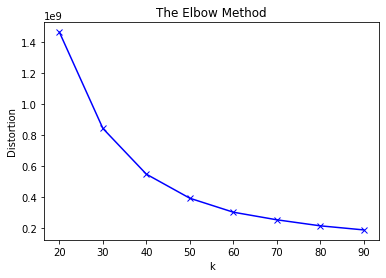

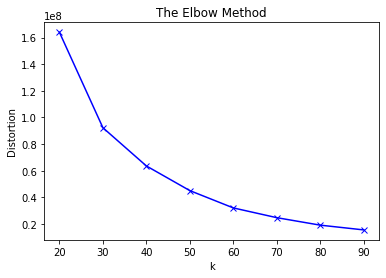

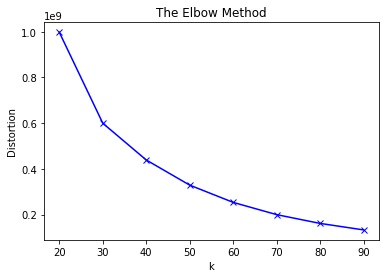

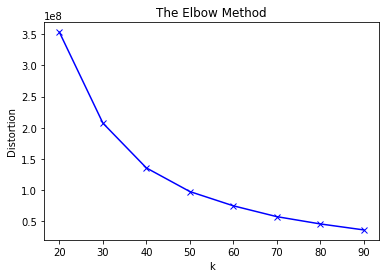

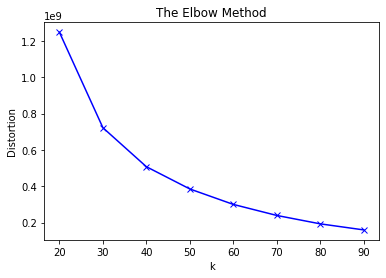

In [ ]:
for dist in top5_district:
  temp = click_points[click_points['Dist_Name'] == dist]
  elbowMethod(temp[['latitude', 'longitude']])

In [ ]:
K = [50, 60, 50, 60, 60]#base on plot above
#teacher give K=30 so n_clusters for all district = 30
points = geopandas.GeoDataFrame()
center = []
for i in range(0, 5):
  #KMeans clustering for each district
  temp = click_points[click_points['Dist_Name'] == top5_district[i]]
  k_means = KMeans(n_clusters=30, random_state=42).fit(temp[['latitude', 'longitude']])
  temp['cluster'] = k_means.labels_

  #find largest cluster
  number_of_occurences = pd.DataFrame(temp['cluster'].value_counts())
  number_of_occurences.reset_index(inplace=True)
  number_of_occurences.columns = ['Cluster', 'Count']
  top = number_of_occurences['Cluster'][0]
  center.append(list(k_means.cluster_centers_[top]))
  temp = temp[temp['cluster'] == top]

  points = pd.concat([points, temp])

center

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

[[1203045.5671048001, 11883592.543770881],
 [1196798.3810092187, 11882263.801378308],
 [1210878.8555734162, 11886086.346184948],
 [1219614.20487948, 11865145.92525063],
 [1216456.9289911885, 11871150.641110655]]

#4.Heat map

In [ ]:
gdf = geopandas.points_from_xy(points.longitude, points.latitude, crs="EPSG:3857")
gdf = gdf.to_crs(epsg=4326)
points['geometry'] = gdf
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in points.geometry ]
geo_df_list

[[10.742724998999998, 106.752173771],
 [10.744854999, 106.75271377099999],
 [10.743894999, 106.752683771],
 [10.745394998999997, 106.75262377099999],
 [10.744404998999999, 106.751783771],
 [10.744404998999999, 106.751873771],
 [10.745064998999998, 106.75220377099998],
 [10.742334999, 106.75262377099999],
 [10.743534998999998, 106.75262377099999],
 [10.743444998999996, 106.752563771],
 [10.743894999, 106.75202377099998],
 [10.744404998999999, 106.751813771],
 [10.742304999, 106.75166377099998],
 [10.742994998999999, 106.75223377099998],
 [10.744314999000002, 106.752383771],
 [10.744074998999999, 106.75211377099998],
 [10.742514998999999, 106.752473771],
 [10.743414998999999, 106.75223377099998],
 [10.742244999, 106.75163377099999],
 [10.742424999, 106.751993771],
 [10.744824999, 106.75211377099998],
 [10.743024999, 106.752293771],
 [10.743714999000002, 106.752173771],
 [10.741884999, 106.751693771],
 [10.744284998999998, 106.75166377099998],
 [10.742484999000002, 106.752173771],
 [10.74

In [ ]:
centroid = geopandas.points_from_xy([row[1] for row in center], [row[0] for row in center], crs="EPSG:3857")
centroid = centroid.to_crs(epsg=4326)
centroid = [[point.xy[1][0], point.xy[0][0]] for point in centroid ]
centroid

[[10.743624346185747, 106.75212812318165],
 [10.688483602500883, 106.74019182718258],
 [10.812750579856731, 106.77453033142295],
 [10.889818422622481, 106.58641932961102],
 [10.861965569138835, 106.64036060994957]]

In [ ]:
colors = ['red', 'darkblue', 'black', 'green', 'purple']

In [ ]:
map = folium.Map(location = geo_df_list[0], zoom_start = 12)
plugins.HeatMap(geo_df_list).add_to(map)
for i in range(5):
  folium.Marker(centroid[i],icon=folium.Icon(color=colors[i])).add_to(map)
map